In [1]:
import os, io, wave, csv, json, re, glob
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy.fftpack import dct
import matplotlib.cm as cm
import matplotlib as mpl
import collections
import seaborn as sns
from keras import optimizers

from sklearn.externals import joblib

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dropout

Using TensorFlow backend.
/opt/jupyterhub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import numpy
import os
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

config = tf.ConfigProto(device_count = {'GPU': 0})
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True

In [4]:
def generateBalancedData(X_more, y_more, size):
    """
    X_more = de input data
    y_more = de label data
    size = de maximum grootte die je wenst bijv. 300000 data totaal
    """
    
    pos_list = [i for i, x in enumerate(y_more) if x == 1][:int(size/2)]
    neg_list = [i for i, x in enumerate(y_more) if x == 0][:int(size/2)]

    balancedDataX = np.concatenate(([X_more[pos] for pos in pos_list], [X_more[neg] for neg in neg_list]), axis=0)
    
    balancedDataY = np.concatenate(([y_more[pos] for pos in pos_list], [y_more[neg] for neg in neg_list]), axis=0)
        
    return [balancedDataX, balancedDataY]

In [5]:
csv_file_name = 'datasetboundary_distance_4ms_news.csv'

In [6]:
# Map waar het csv bestand zit
data_corpus_path = '/datb/aphasia/languagedata/corpus/dataset/' + csv_file_name


# Inlezen CSV bestand
df_corpus_data = pd.read_csv(data_corpus_path, sep=',', skiprows=1,
                             names=['region', 'label', 'sample_rate', 'begin', 'end', 'audiopath'])


# Voor het weghalen van 'nan' rows in de column "region"
df_corpus = df_corpus_data.dropna(subset=['region'])

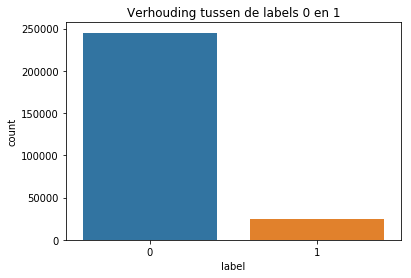

In [7]:
fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='label', data=df_corpus)
plt.title("Verhouding tussen de labels 0 en 1")
plt.show()

In [8]:
# Get input data
X = []

for x in df_corpus.region:
    trans = [float(y) for y in x.split('|')]
    X.append(trans)

# Get labels
y = [int(x) for x in df_corpus.label]

print('Before generating more 1 labels data')
print('X:{}'.format(len(X)))
print('y:{}'.format(len(y)))

Before generating more 1 labels data
X:269709
y:269709


In [9]:
dataSize = 70000

In [10]:
X_more, y_more = generateBalancedData(X, y, dataSize)

print('After generating more 1 labels data')
print('X:{}'.format(len(X_more)))
print('y:{}'.format(len(y_more)))

After generating more 1 labels data
X:59519
y:59519


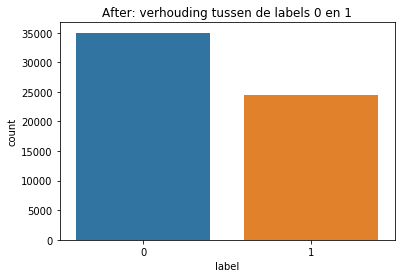

In [11]:
fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='label', data=pd.DataFrame({'label':y_more}))
plt.title("After: verhouding tussen de labels 0 en 1")
plt.show()

In [12]:
test_size = 0.20
random_state = 42

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_more, y_more, test_size=test_size, 
                                                    random_state=random_state, stratify=y_more)

In [14]:

import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.utils import plot_model
from IPython.display import SVG



In [15]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)

In [16]:
# define baseline model
def  create_baseline():
    # create model
    model = Sequential()
    model.add(Dropout(0.4, input_shape=(52,)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    # Compile model
    adam = optimizers.Adam(lr=0.003)
    model.compile(loss='categorical_crossentropy', optimizer= adam, metrics=['accuracy'])
    
    return model

In [17]:
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=1000, verbose=1)
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
# results = cross_val_score(estimator, X_train, encoded_Y, cv=kfold)
# print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Train on 38092 samples, validate on 9523 samples
Epoch 1/100
38092/38092 [==============================] - 4s - loss: 0.6878 - acc: 0.5748 - val_loss: 0.6749 - val_acc: 0.5928
Epoch 2/100
38092/38092 [==============================] - 1s - loss: 0.6780 - acc: 0.5850 - val_loss: 0.6752 - val_acc: 0.5918
Epoch 3/100
38092/38092 [==============================] - 1s - loss: 0.6763 - acc: 0.5862 - val_loss: 0.6743 - val_acc: 0.5930
Epoch 4/100
38092/38092 [==============================] - 1s - loss: 0.6753 - acc: 0.5865 - val_loss: 0.6731 - val_acc: 0.5951
Epoch 5/100
38092/38092 [==============================] - 1s - loss: 0.6741 - acc: 0.5897 - val_loss: 0.6721 - val_acc: 0.5939
Epoch 6/100
38092/38092 [==============================] - 1s - loss: 0.6730 - acc: 0.5899 - val_loss: 0.6705 - val_acc: 0.5947
Epoch 7/100
38092/38092 [==============================] - 1s - loss: 0.6720 - acc: 0.5930 - val_loss: 0.6703 - val_acc: 0.5979
Epoch 8/100
38092/38092 [==============================

38092/38092 [==============================] - 1s - loss: 0.6535 - acc: 0.6139 - val_loss: 0.6662 - val_acc: 0.6165
Epoch 65/100
38092/38092 [==============================] - 1s - loss: 0.6546 - acc: 0.6147 - val_loss: 0.6614 - val_acc: 0.6143
Epoch 66/100
38092/38092 [==============================] - 1s - loss: 0.6544 - acc: 0.6118 - val_loss: 0.6652 - val_acc: 0.6134
Epoch 67/100
38092/38092 [==============================] - 1s - loss: 0.6543 - acc: 0.6153 - val_loss: 0.6621 - val_acc: 0.6170
Epoch 68/100
38092/38092 [==============================] - 1s - loss: 0.6526 - acc: 0.6147 - val_loss: 0.6689 - val_acc: 0.6154
Epoch 69/100
38092/38092 [==============================] - 0s - loss: 0.6555 - acc: 0.6096 - val_loss: 0.6638 - val_acc: 0.6141
Epoch 70/100
38092/38092 [==============================] - 0s - loss: 0.6546 - acc: 0.6120 - val_loss: 0.6604 - val_acc: 0.6127
Epoch 71/100
38092/38092 [==============================] - 1s - loss: 0.6550 - acc: 0.6142 - val_loss: 0.6631

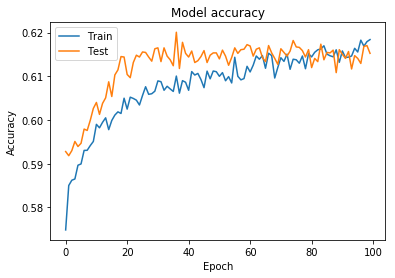

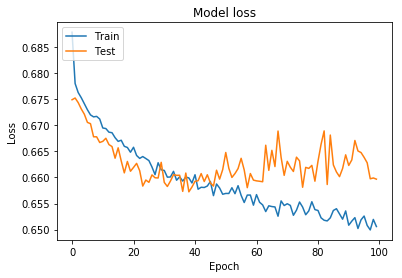

In [18]:
history = estimator.fit(X_train, encoded_Y, validation_split=0.20, epochs=100, batch_size=128, verbose=1)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()